In [1]:
%cd ..
%load_ext autoreload
%autoreload 2

/home/amir/rqc_internship/frame_stack


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from os.path import join as jn
import os
import yaml
import torch
from torchinfo import summary
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader, Dataset


In [43]:
from video_pipeline.video_module import *

import matplotlib.pyplot as plt
from IPython.display import clear_output
import time 

In [4]:
with open('params.yaml') as conf_file:
    config = yaml.safe_load(conf_file)
with open('pathes.yaml') as conf_file:
    path_config = yaml.safe_load(conf_file)

pressure_path = path_config['p_video_path']
signal_path = path_config['s_video_path']


#### opening dataset file and visualizing video

In [19]:

input_path = path_config['s_video_path']
output_path = path_config['p_video_path']

tr = config['video_train']
frames_number, frames_interval = tr["frames_number"], tr["frames_interval"]

def get_elemenst_from_dataset(slice, key_id=10):
    '''
    usage example:
    i = 100
    pressure, signal = get_elemenst_from_dataset(slice(i, i+20))
    pressure.shape, signal.shape
    plt.imshow(pressure[0])
    plt.show()
    '''
    pressure_path, signal_path = jn(output_path, 'test'), jn(input_path, 'test')
    name = "test.hdf5"
    # i = 50

    with h5py.File(jn(signal_path, name)) as signal_file, \
            h5py.File(jn(pressure_path, name)) as pres_file:
            key = list(signal_file.keys())[key_id]
                # for key in tqdm(signal_file.keys(), dynamic_ncols=True, position=1, leave=False):

            signal = (signal_file[key][slice].astype(np.float32))
            pressure = (pres_file[key][slice].astype(np.float32))
    return pressure, signal

In [56]:
# loading data
pressure, signal = get_elemenst_from_dataset(slice(300), key_id=100)
# plt.imshow(pressure[0])
# plt.show()

### ML model loading

In [8]:
import torch_sensor_lib as tsl
sim = tsl.FiberSimulator(config)

In [9]:

if not torch.cuda.is_available():
    print('CUDA is NOT available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# %%
tr = config['video_train']

CUDA is NOT available.  Training on CPU ...


In [10]:

signal_shape, pressure_shape = (1, 4, 64), (64, 64)
print('input chain shape: ', signal_shape, '\noutput chain shape: ',
      pressure_shape)

model_name = tr['model_name']
from video_pipeline import models_src

model_class = eval(f"models_src.{model_name}")

args = []
if model_name.startswith("Param"):
    layers = tr['layers']
    args.append(layers)
args.append(frames_number)
args.append(frames_interval)
model = model_class(pressure_shape[-2:], signal_shape[-2:], *args)
model = model.to(device)

input chain shape:  (1, 4, 64) 
output chain shape:  (64, 64)


In [45]:
checkpoint = torch.load("data/365_id_model.pt",
                     map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

model.eval();

До сюда шапка, которую нужно запускать каждый раз.

#### comparing simulation and saved results

In [ ]:
import torch_sensor_lib as tsl
sim = tsl.FiberSimulator(config)

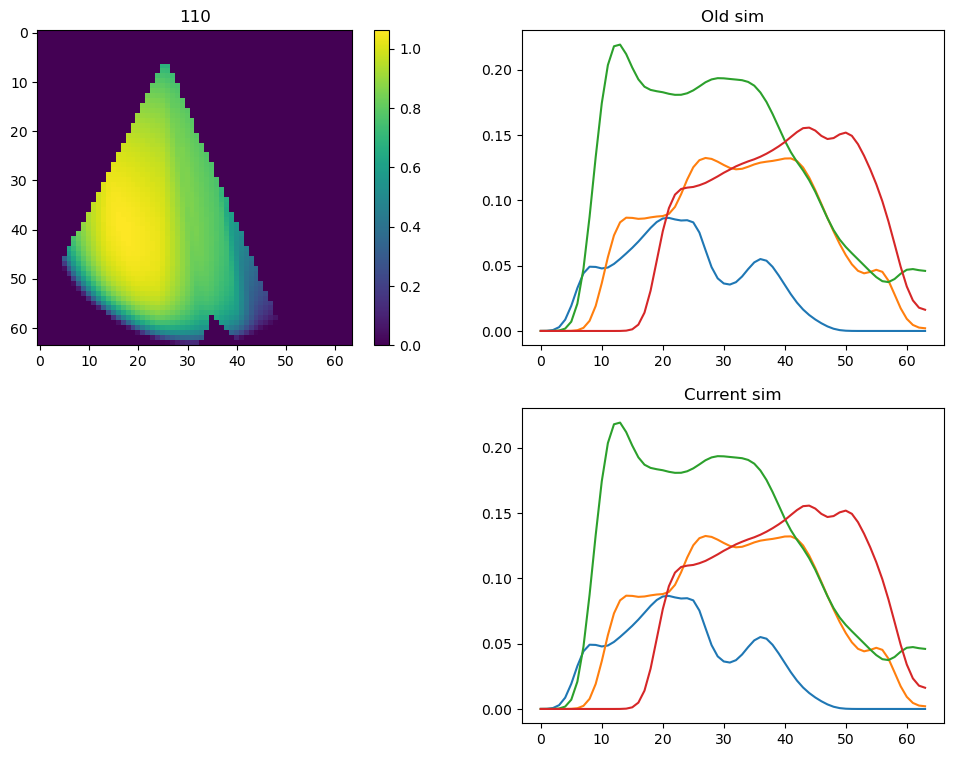

In [ ]:

for i in range(110, 115, 5):
    clear_output(wait=True)
    plt.figure(figsize=(12, 9))
    plt.subplot(2, 2, 1)
    plt.imshow(pressure[i])
    plt.title(f"{i}")
    plt.colorbar()
    
    plt.subplot(2, 2, 2)
    plt.plot(signal[i].T)
    plt.title("Old sim")
    
    plt.subplot(2, 2, 4)
    plt.plot(sim.fiber_real_sim(pressure[i])[0].T)
    plt.title("Current sim")
    plt.show()
    time.sleep(0.5)

#### Функция для полного тестирования симуляции

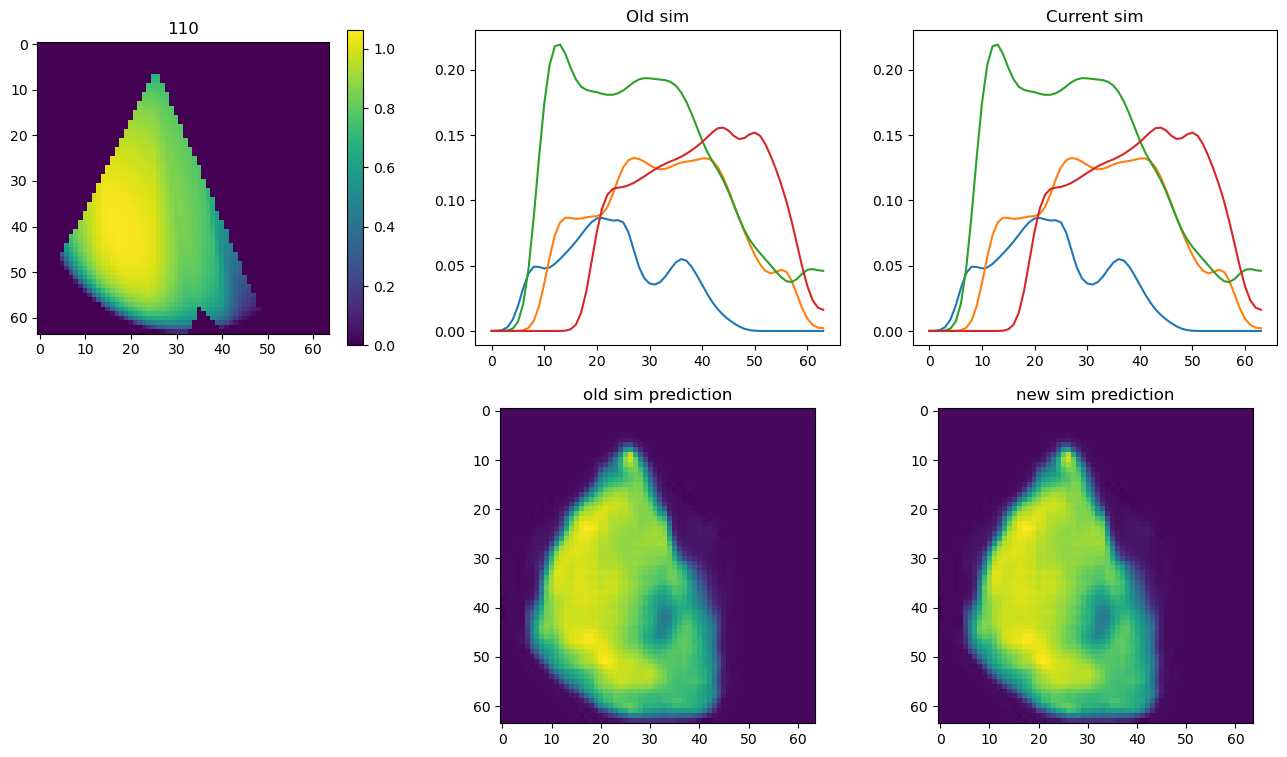

In [22]:

for i in range(110, 115, 5):
    clear_output(wait=True)
    plt.figure(figsize=(16, 9))
    plt.subplot(2, 3, 1)
    plt.imshow(pressure[i])
    plt.title(f"{i}")
    plt.colorbar()
    
    plt.subplot(2, 3, 2)
    plt.plot(signal[i].T)
    plt.title("Old sim")
    
    plt.subplot(2, 3, 3)
    new_signal = sim.fiber_real_sim(pressure[i])
    plt.plot(new_signal[0].T)
    plt.title("Current sim")
    
    plt.subplot(2, 3, 5)
    map = predict(model, signal[i:i+1], device)
    plt.imshow(map[0])
    plt.title("old sim prediction")
    
    plt.subplot(2, 3, 6)
    map = predict(model, new_signal, device)
    plt.imshow(map[0])
    plt.title("new sim prediction")
    
    plt.show()
    time.sleep(0.5)

#### Сделал в симуляции блюр задаваемым в мм-ах

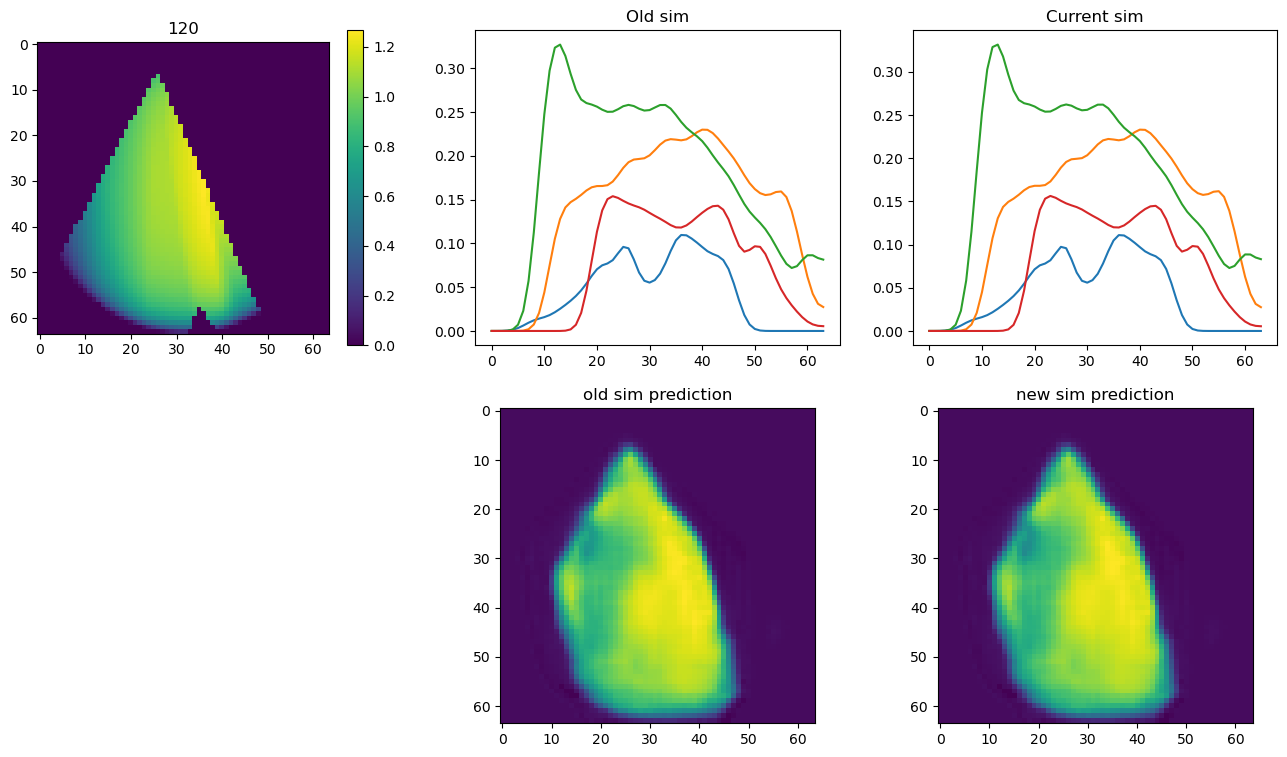

In [27]:

for i in range(60, 121, 20):
    clear_output(wait=True)
    plt.figure(figsize=(16, 9))
    plt.subplot(2, 3, 1)
    plt.imshow(pressure[i])
    plt.title(f"{i}")
    plt.colorbar()
    
    plt.subplot(2, 3, 2)
    plt.plot(signal[i].T)
    plt.title("Old sim")
    
    plt.subplot(2, 3, 3)
    new_signal = sim.fiber_real_sim(pressure[i])
    plt.plot(new_signal[0].T)
    plt.title("Current sim")
    
    plt.subplot(2, 3, 5)
    map = predict(model, signal[i:i+1], device)
    plt.imshow(map[0])
    plt.title("old sim prediction")
    
    plt.subplot(2, 3, 6)
    map = predict(model, new_signal, device)
    plt.imshow(map[0])
    plt.title("new sim prediction")
    
    plt.show()
    time.sleep(0.5)

### Меняю симуляцию пропускания

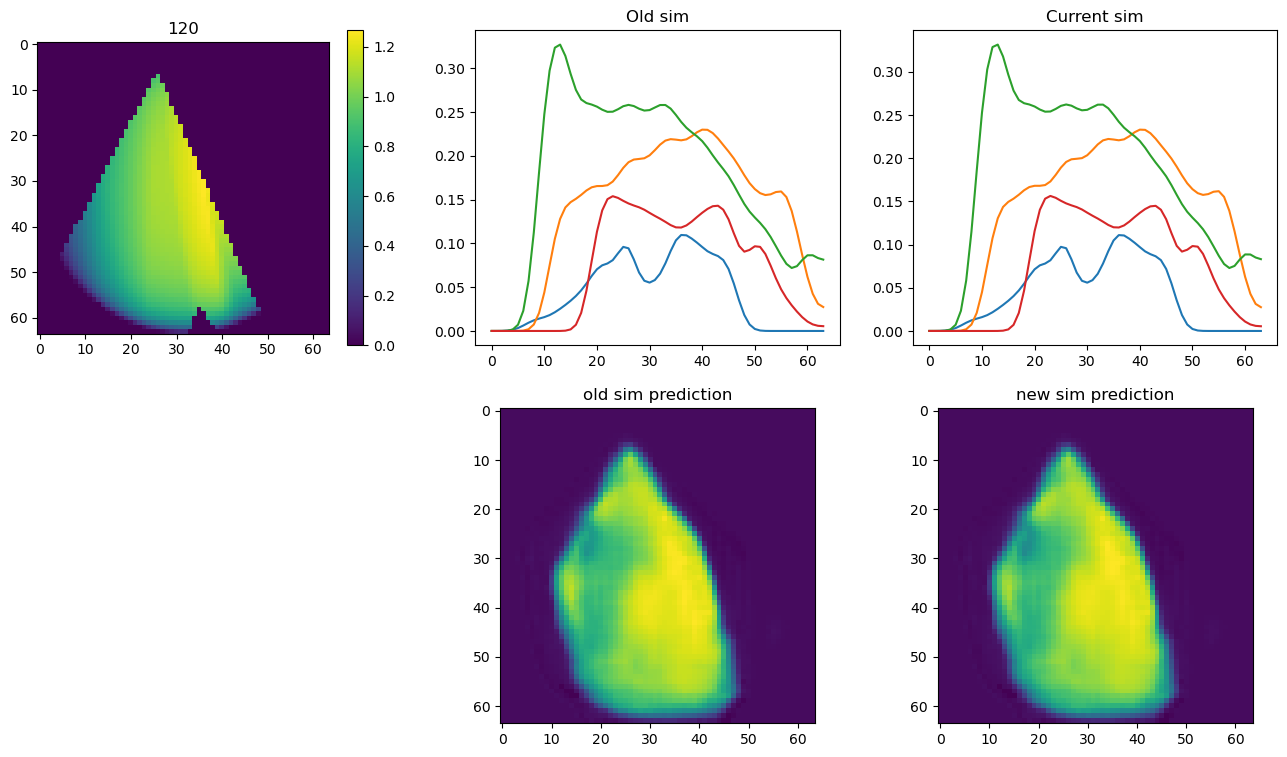

In [34]:

for i in range(120, 121, 20):
    clear_output(wait=True)
    plt.figure(figsize=(16, 9))
    plt.subplot(2, 3, 1)
    plt.imshow(pressure[i])
    plt.title(f"{i}")
    plt.colorbar()
    
    plt.subplot(2, 3, 2)
    plt.plot(signal[i].T)
    plt.title("Old sim")
    
    plt.subplot(2, 3, 3)
    new_signal = sim.fiber_real_sim(pressure[i])
    plt.plot(new_signal[0].T)
    plt.title("Current sim")
    
    plt.subplot(2, 3, 5)
    map = predict(model, signal[i:i+1], device)
    plt.imshow(map[0])
    plt.title("old sim prediction")
    
    plt.subplot(2, 3, 6)
    map = predict(model, new_signal, device)
    plt.imshow(map[0])
    plt.title("new sim prediction")
    
    plt.show()
    time.sleep(0.5)

#### Перешел от умножений пропускания к суммированию экспаненциального показателя по волокну.

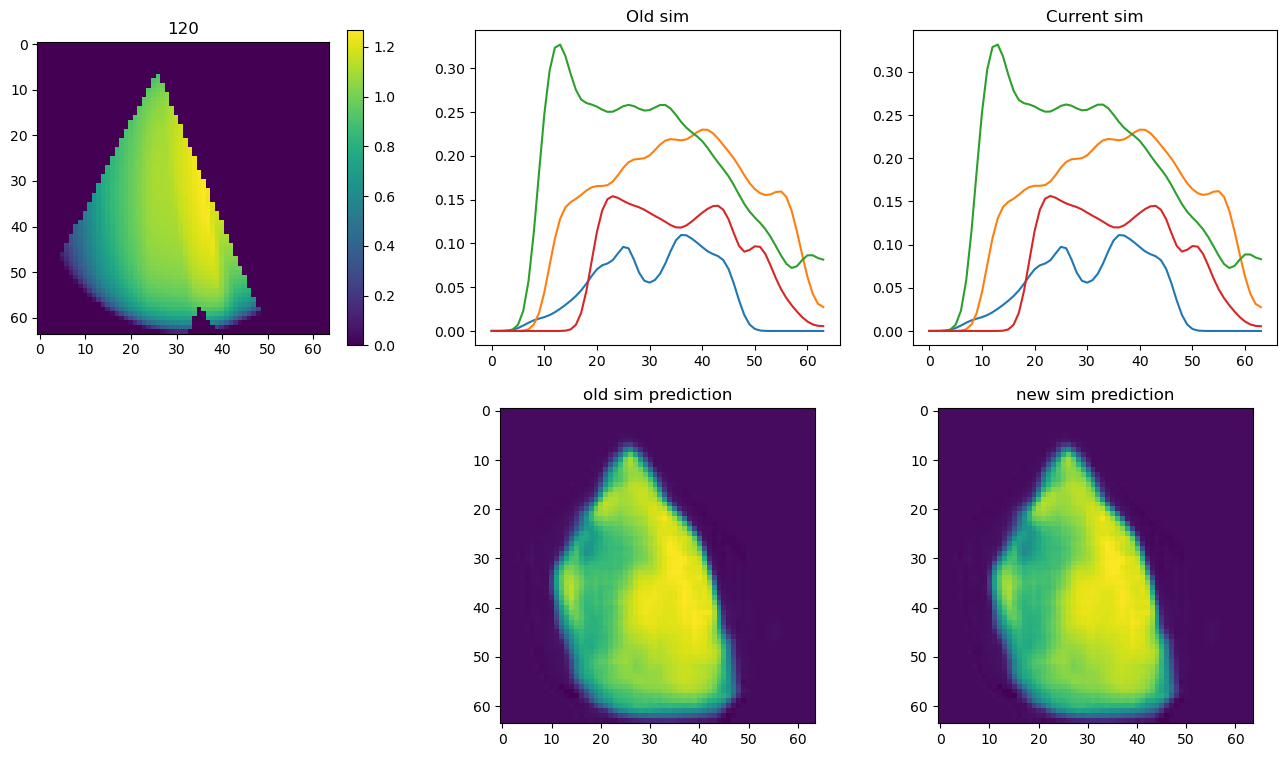

In [16]:

for i in range(120, 121, 20):
    clear_output(wait=True)
    plt.figure(figsize=(16, 9))
    plt.subplot(2, 3, 1)
    plt.imshow(pressure[i])
    plt.title(f"{i}")
    plt.colorbar()
    
    plt.subplot(2, 3, 2)
    plt.plot(signal[i].T)
    plt.title("Old sim")
    
    plt.subplot(2, 3, 3)
    new_signal = sim.fiber_real_sim(pressure[i])
    plt.plot(new_signal[0].T)
    plt.title("Current sim")
    
    plt.subplot(2, 3, 5)
    map = predict(model, signal[i:i+1], device)
    plt.imshow(map[0])
    plt.title("old sim prediction")
    
    plt.subplot(2, 3, 6)
    map = predict(model, new_signal, device)
    plt.imshow(map[0])
    plt.title("new sim prediction")
    
    plt.show()
    time.sleep(0.5)

### меняю аналитическую функцию на интерполяционную

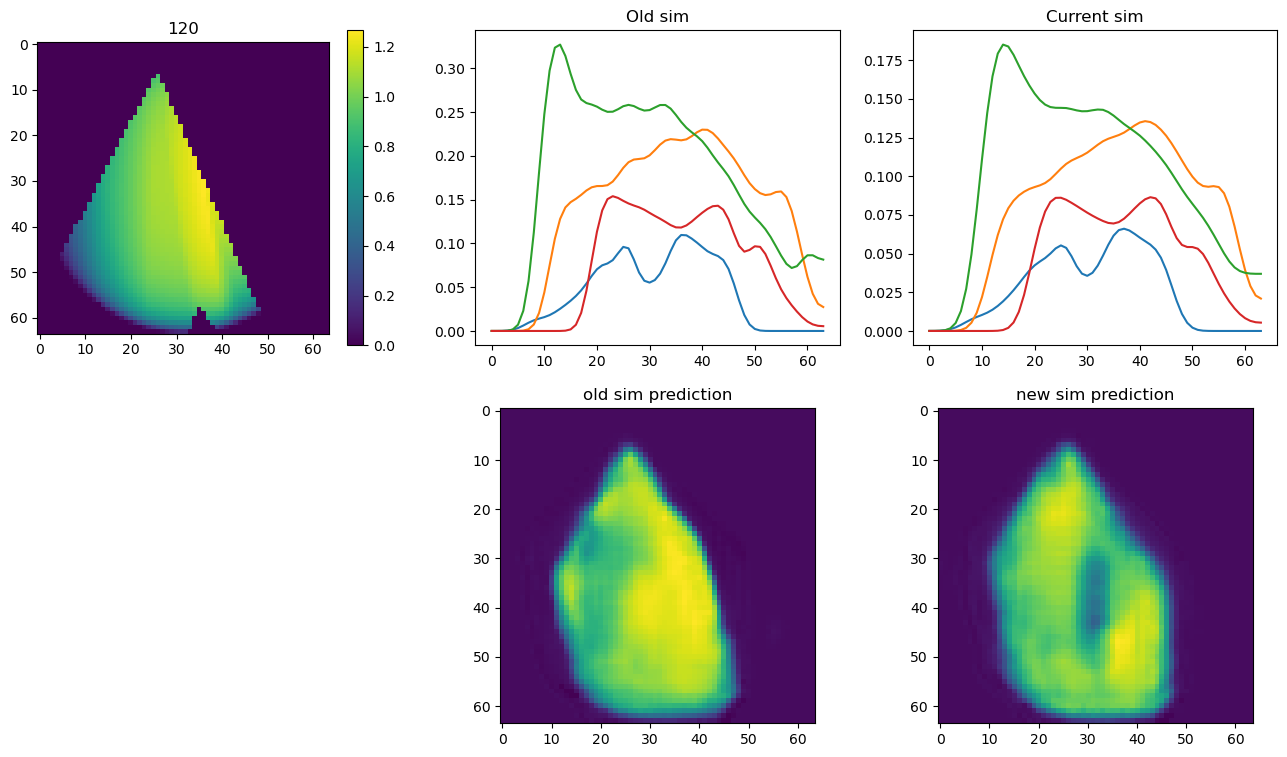

In [48]:

for i in range(120, 121, 20):
    clear_output(wait=True)
    plt.figure(figsize=(16, 9))
    plt.subplot(2, 3, 1)
    plt.imshow(pressure[i])
    plt.title(f"{i}")
    plt.colorbar()
    
    plt.subplot(2, 3, 2)
    plt.plot(signal[i].T)
    plt.title("Old sim")
    
    plt.subplot(2, 3, 3)
    new_signal = sim.fiber_real_sim(pressure[i])
    plt.plot(new_signal[0].T)
    plt.title("Current sim")
    
    plt.subplot(2, 3, 5)
    map = predict(model, signal[i:i+1], device)
    plt.imshow(map[0])
    plt.title("old sim prediction")
    
    plt.subplot(2, 3, 6)
    map = predict(model, new_signal, device)
    plt.imshow(map[0])
    plt.title("new sim prediction")
    plt.show()
    time.sleep(0.5)


(Чтобы отсюда код работал нужно запустить opening dataset и  model loading)

In [21]:
# config['env']['phys']['sigma'] = 0.9

config['env']['bimodal']['intermode_matrix'] = [[1, 0], 
                                                [1, 1]]

import torch_bimodal_sim_lib as tbsl
simb = tbsl.FiberSimulator(config)

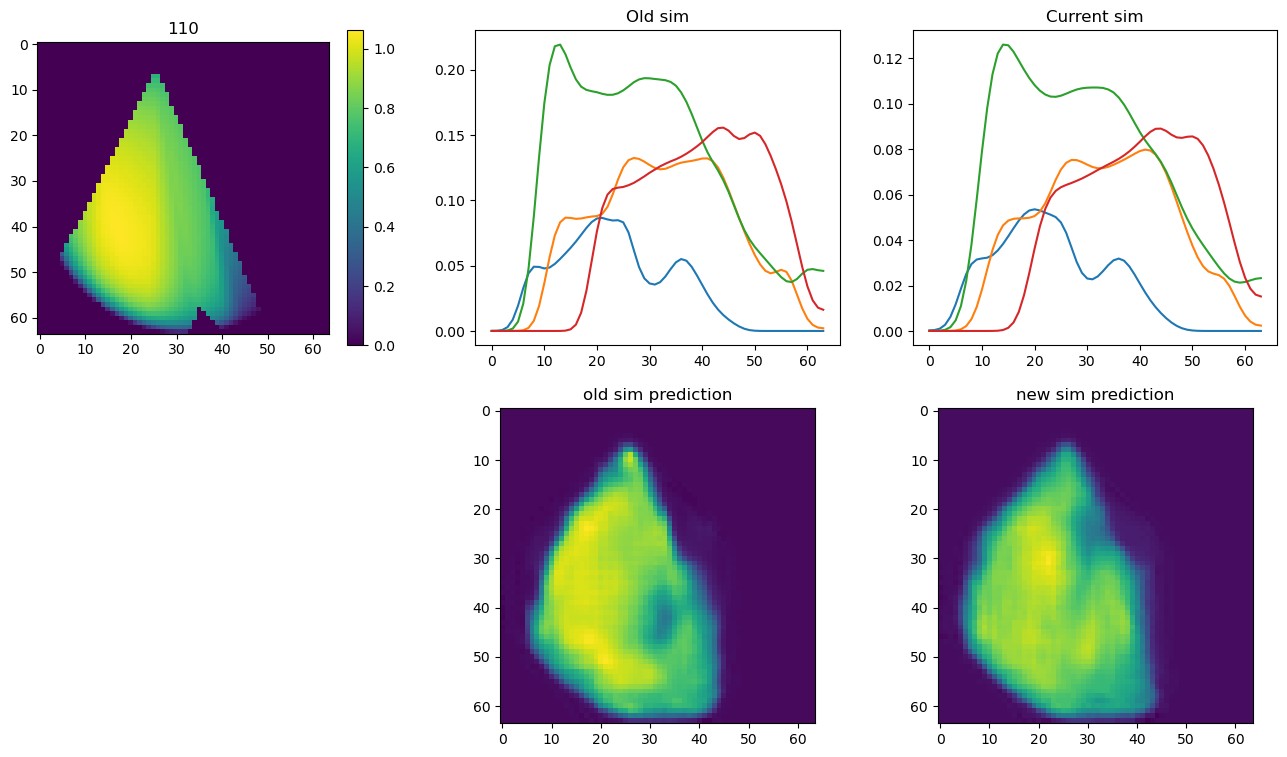

In [22]:

for i in range(110, 115, 5):
    clear_output(wait=True)
    plt.figure(figsize=(16, 9))
    plt.subplot(2, 3, 1)
    plt.imshow(pressure[i])
    plt.title(f"{i}")
    plt.colorbar()
    
    plt.subplot(2, 3, 2)
    plt.plot(signal[i].T)
    plt.title("Old sim")
    
    plt.subplot(2, 3, 3)
    new_signal = sim.fiber_real_sim(pressure[i])
    plt.plot(new_signal[0].T)
    plt.title("Current sim")
    
    plt.subplot(2, 3, 5)
    map = predict(model, signal[i:i+1], device)
    plt.imshow(map[0])
    plt.title("old sim prediction")
    
    plt.subplot(2, 3, 6)
    map = predict(model, new_signal, device)
    plt.imshow(map[0])
    plt.title("new sim prediction")
    
    plt.show()
    time.sleep(0.5)

Ничего себе, взяло сразу и заработало =)))

Оценка адекватности параметров симуляции:
сторона -- 64 точки, расстояние между волокнами -- 0.35 мм, \
значит размер картинки 22 мм. Примерно то, что нам нужно. 

Период эффекта -- 2.3 мм, что = 6 клеточек. Ну и нормально. \
Вопрос правда стоит в точности симуляции при таком маленьком шаге.


### 6.04.2023

нейросетка не обучалась на сигнале с новой симуляцией. Лосс был близок к +inf. Выясняю в чем причина.

In [54]:
with open('params.yaml') as conf_file:
    config = yaml.safe_load(conf_file)
print("Matrix", *config['env']['bimodal']['intermode_matrix'], sep='\n')
print("sigma (mm):", config['env']['phys']['sigma'])
import torch_bimodal_sim_lib as tbsl
simb = tbsl.FiberSimulator(config)

Matrix
[1, 0]
[0, 1]
sigma (mm): 1


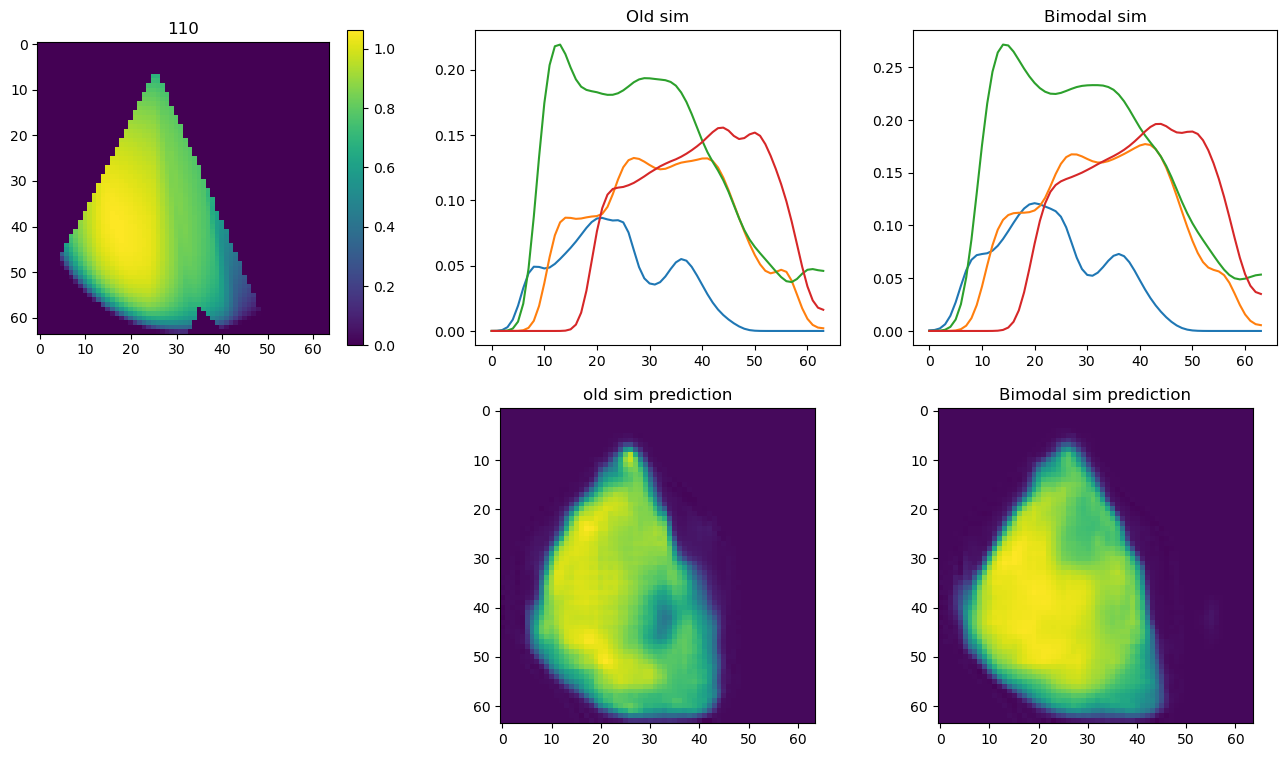

In [57]:

for i in range(110, 115, 5):
    clear_output(wait=True)
    plt.figure(figsize=(16, 9))
    plt.subplot(2, 3, 1)
    plt.imshow(pressure[i])
    plt.title(f"{i}")
    plt.colorbar()
    
    plt.subplot(2, 3, 2)
    plt.plot(signal[i].T)
    plt.title("Old sim")
    
    plt.subplot(2, 3, 3)
    new_signal = simb.fiber_real_sim(pressure[i])
    plt.plot(new_signal[0].T)
    plt.title("Bimodal sim")
    
    plt.subplot(2, 3, 5)
    map = predict(model, signal[i:i+1], device)
    plt.imshow(map[0])
    plt.title("old sim prediction")
    
    plt.subplot(2, 3, 6)
    map = predict(model, new_signal, device)
    plt.imshow(map[0])
    plt.title("Bimodal sim prediction")
    
    plt.show()
    time.sleep(0.5)

смотрю другие предметы из датасета

101, 102

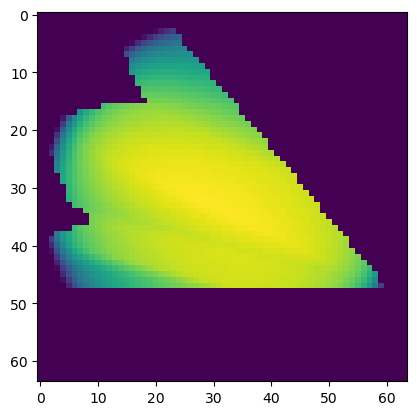

In [63]:
# loading data
key_id = 103
pressure, signal = get_elemenst_from_dataset(slice(300), key_id=key_id)
plt.imshow(pressure[200])

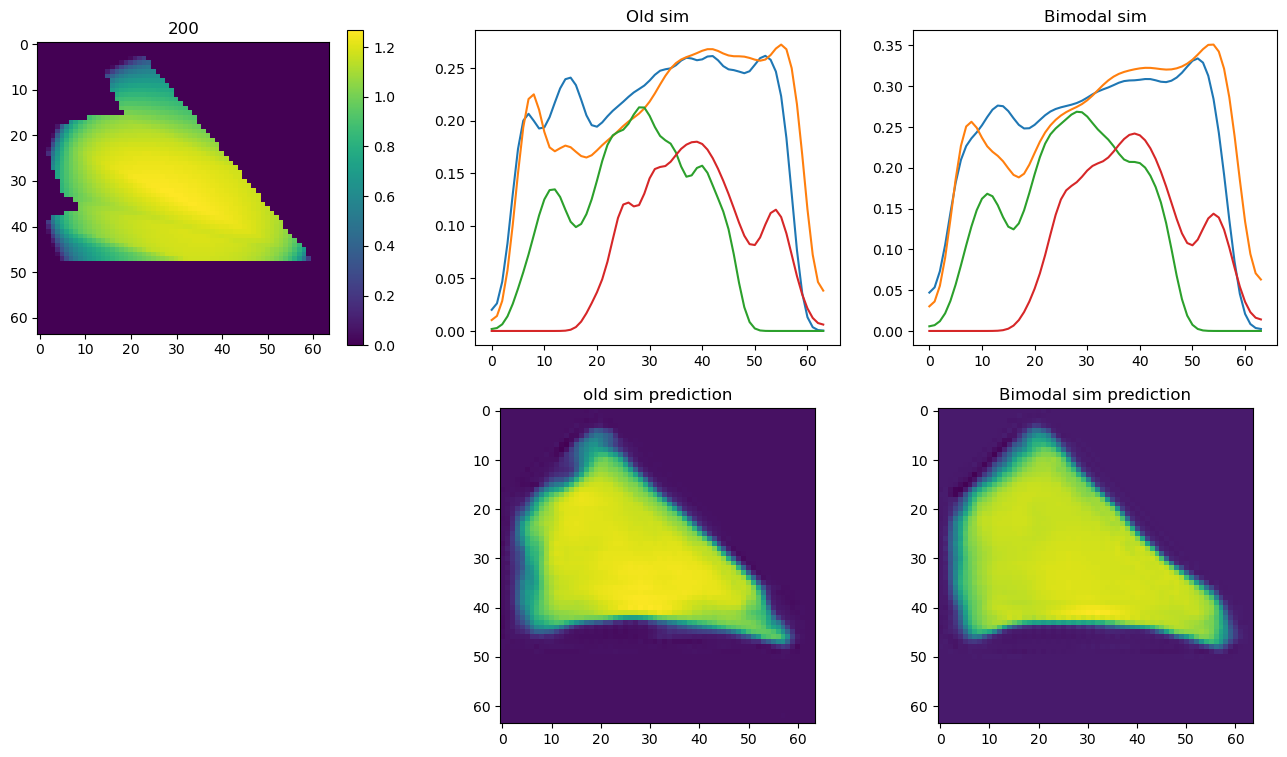

In [65]:

# for i in range(115, 120, 5):
i = 200

clear_output(wait=True)
plt.figure(figsize=(16, 9))
plt.subplot(2, 3, 1)
plt.imshow(pressure[i])
plt.title(f"{i}")
plt.colorbar()

plt.subplot(2, 3, 2)
plt.plot(signal[i].T)
plt.title("Old sim")

plt.subplot(2, 3, 3)
new_signal = simb.fiber_real_sim(pressure[i])
plt.plot(new_signal[0].T)
plt.title("Bimodal sim")

plt.subplot(2, 3, 5)
map = predict(model, signal[i:i+1], device)
plt.imshow(map[0])
plt.title("old sim prediction")

plt.subplot(2, 3, 6)
map = predict(model, new_signal, device)
plt.imshow(map[0])
plt.title("Bimodal sim prediction")

plt.show()
time.sleep(0.5)